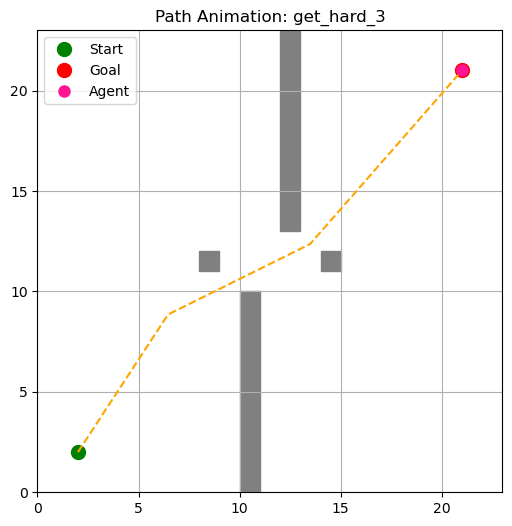

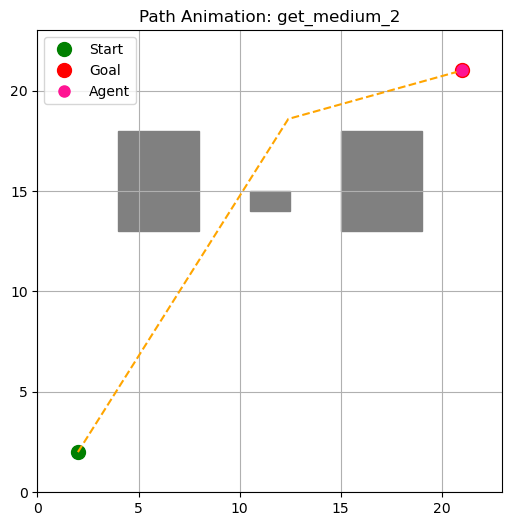

In [1]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
import ipywidgets as widgets
from IPython.display import clear_output, display
import time

# Import the TestEnvironments class from the uploaded module
from testEnvironments import TestEnvironments

# ---------- LOAD ENVIRONMENTS ----------
test_envs = TestEnvironments()
scene_dict = test_envs.get_all_scenes()

# Transform scenes into usable format
def convert_scene_to_env(name, scene):
    start = scene.get("start", Point(0, 0).buffer(0.8))
    goal = scene.get("goal", Point(0, 0).buffer(0.8))
    obstacles = [geom for key, geom in scene.items() if key not in ["start", "goal"]]
    start_center = start.centroid.coords[0]
    goal_center = goal.centroid.coords[0]
    return {
        "map_bounds": (0, 23, 0, 23),
        "start": start_center,
        "goal": goal_center,
        "obstacles": obstacles
    }

environments = {name: convert_scene_to_env(name, scene) for name, scene in scene_dict.items()}

# ---------- PARAMETERS ----------
samples_per_region = 40
lazy_k_neighbors = 8
num_regions = 4
collision_checks = 0

# ---------- PRM UTILITY FUNCTIONS ----------
def is_collision(p1, p2, obstacles):
    global collision_checks
    collision_checks += 1
    line = LineString([p1, p2])
    return any(line.crosses(obs) or line.within(obs) for obs in obstacles)

def sample_free(bounds, obstacles):
    minx, maxx, miny, maxy = bounds
    while True:
        x, y = random.uniform(minx, maxx), random.uniform(miny, maxy)
        if not any(obs.contains(Point(x, y)) for obs in obstacles):
            return (x, y)

def build_lazy_prm(region_bounds, num_samples, k, obstacles):
    G = nx.Graph()
    nodes = [sample_free(region_bounds, obstacles) for _ in range(num_samples)]
    G.add_nodes_from(nodes)
    for node in nodes:
        distances = sorted(
            ((other, np.linalg.norm(np.subtract(node, other))) for other in nodes if other != node),
            key=lambda x: x[1]
        )[:k]
        for neighbor, dist in distances:
            G.add_edge(node, neighbor, weight=dist)
    return G

def build_visibility_prm(nodes, obstacles):
    G = nx.Graph()
    for node in nodes:
        G.add_node(node)
        for other in G.nodes:
            if other != node and not G.has_edge(node, other):
                if not is_collision(node, other, obstacles):
                    dist = np.linalg.norm(np.subtract(node, other))
                    G.add_edge(node, other, weight=dist)
    return G

def build_hierarchical_visibility_lazy_prm(global_bounds, num_regions, samples_per_region, k, obstacles):
    minx, maxx, miny, maxy = global_bounds
    midx, midy = (minx + maxx) / 2, (miny + maxy) / 2
    regions = [
        (minx, midx, miny, midy),
        (midx, maxx, miny, midy),
        (minx, midx, midy, maxy),
        (midx, maxx, midy, maxy)
    ]
    local_graphs = [build_lazy_prm(region, samples_per_region, k, obstacles) for region in regions]
    all_nodes = [node for g in local_graphs for node in g.nodes]
    global_graph = build_visibility_prm(all_nodes, obstacles)
    for g in local_graphs:
        global_graph.add_edges_from(g.edges(data=True))
    return global_graph

def validate_lazy_path(G, path, obstacles):
    valid = True
    for u, v in zip(path[:-1], path[1:]):
        if is_collision(u, v, obstacles):
            G.remove_edge(u, v)
            valid = False
    return valid

def lazy_shortest_path(G, start, goal, obstacles):
    while True:
        try:
            path = nx.shortest_path(G, source=start, target=goal, weight='weight')
        except nx.NetworkXNoPath:
            return None
        if validate_lazy_path(G, path, obstacles):
            return path

def plot_prm(G, obstacles, start=None, goal=None, path=None, environment_name=""):
    plt.figure(figsize=(8, 8))
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray')
    for (u, v) in G.edges:
        plt.plot([u[0], v[0]], [u[1], v[1]], color='blue', linewidth=0.5)
    xs, ys = zip(*G.nodes)
    plt.scatter(xs, ys, color='black', s=5)
    if start:
        plt.scatter(*start, color='green', s=100, label="Start")
    if goal:
        plt.scatter(*goal, color='red', s=100, label="Goal")
    if path:
        px, py = zip(*path)
        plt.plot(px, py, color='orange', linewidth=2, label="Path")
    plt.xlim(0, 23)
    plt.ylim(0, 23)
    plt.legend()
    plt.title(f"PRM: {environment_name}")
    plt.grid(True)
    plt.show()

# ---------- MAIN EXECUTION FUNCTION ----------
def interactive_plot(samples_per_region, lazy_k_neighbors, environment_name):
    global collision_checks
    collision_checks = 0

    start_time = time.time()

    environment = environments[environment_name]
    obstacles = environment["obstacles"]
    map_bounds = environment["map_bounds"]
    start = environment["start"]
    goal = environment["goal"]

    G = build_hierarchical_visibility_lazy_prm(map_bounds, num_regions, samples_per_region, lazy_k_neighbors, obstacles)

    G.add_node(start)
    G.add_node(goal)

    for node in list(G.nodes):
        if node in [start, goal]:
            continue
        if not is_collision(node, start, obstacles):
            G.add_edge(node, start, weight=np.linalg.norm(np.subtract(node, start)))
        if not is_collision(node, goal, obstacles):
            G.add_edge(node, goal, weight=np.linalg.norm(np.subtract(node, goal)))

    path = lazy_shortest_path(G, start, goal, obstacles)
    planning_time = time.time() - start_time
    path_length = sum(np.linalg.norm(np.subtract(u, v)) for u, v in zip(path[:-1], path[1:])) if path else 0

    with output_area:
        clear_output(wait=True)
        print("\n----------- Benchmark Results -----------")
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Collision checks performed: {collision_checks}")
        if path:
            print(f"Path found with length: {path_length:.2f}")
        else:
            print("No valid path found.")
        print(f"Planning time: {planning_time:.2f} seconds")

        plot_prm(G, obstacles, start, goal, path, environment_name)

        if path:
            animate_path(path, obstacles, start, goal, map_bounds, environment_name)
        else:
            print("No path to animate.")


# ---------- UI CONTROLS ----------
environment_dropdown = widgets.Dropdown(
    options=list(environments.keys()),
    value=list(environments.keys())[0],
    description='Environment:'
)

samples_slider = widgets.IntSlider(
    value=samples_per_region,
    min=10,
    max=100,
    step=1,
    description='Samples/Region:'
)

k_slider = widgets.IntSlider(
    value=lazy_k_neighbors,
    min=3,
    max=20,
    step=1,
    description='K Neighbors:'
)

run_button = widgets.Button(
    description='Run PRM',
    button_style='success'
)

output_area = widgets.Output()

def run_clicked(_):
    interactive_plot(samples_slider.value, k_slider.value, environment_dropdown.value)

run_button.on_click(run_clicked)

ui = widgets.VBox([environment_dropdown, samples_slider, k_slider, run_button, output_area])
display(ui)

#------------------------Animation----------------------------
from matplotlib import animation
from scipy.interpolate import interp1d
from IPython.display import HTML

def animate_path(path, obstacles, start, goal, map_bounds, environment_name):
    if len(path) < 2:
        print("Path too short to animate.")
        return

    # Interpolate to 60 frames along the path
    path = np.array(path)
    dists = np.cumsum([0] + [np.linalg.norm(path[i] - path[i-1]) for i in range(1, len(path))])
    total_dist = dists[-1]
    interp_dist = np.linspace(0, total_dist, 60)

    fx = interp1d(dists, path[:, 0], kind='linear')
    fy = interp1d(dists, path[:, 1], kind='linear')
    interpolated_path = np.column_stack((fx(interp_dist), fy(interp_dist)))

    fig, ax = plt.subplots(figsize=(6, 6))

    for obs in obstacles:
        x, y = obs.exterior.xy
        ax.fill(x, y, color='gray')

    ax.set_xlim(map_bounds[0], map_bounds[1])
    ax.set_ylim(map_bounds[2], map_bounds[3])
    ax.set_title(f"Path Animation: {environment_name}")
    ax.grid(True)

    ax.plot(*start, 'go', markersize=10, label='Start')
    ax.plot(*goal, 'ro', markersize=10, label='Goal')
    ax.plot(path[:, 0], path[:, 1], linestyle='--', color='orange', linewidth=1.5)

    pink_dot, = ax.plot([], [], 'o', color='deeppink', markersize=8, label='Agent')
    ax.legend()

    def init():
        pink_dot.set_data([], [])
        return (pink_dot,)

    def update(frame):
        x, y = interpolated_path[frame]
        pink_dot.set_data([x], [y])
        return (pink_dot,)

    ani = animation.FuncAnimation(
        fig, update, frames=len(interpolated_path),
        init_func=init, interval=100, blit=True, repeat=False
    )

    display(HTML(ani.to_jshtml()))
